# SGDClassifier训练+分析
> 从头到尾，训练分析过一遍
- 预处理
- 全数据集训练

In [1]:
# to build and test ml model

# Common imports 
import sys

import sklearn

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 加载mnist数据集
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# 利用预先划分好的训练集和测试集

X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [4]:
from sklearn.ensemble import RandomForestClassifier

# 全训练集——训练
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)
# 训练耗时差不多1min

RandomForestClassifier()

In [6]:
# 模型保存
import joblib
joblib.dump(rf_clf,"rf_model_all_training.pkl")
# to load
# kn_model_all_training_loaded = joblib.load("rf_model_all_training.pkl")

['rf_model_all_training.pkl']

In [8]:
# 简单的用测试集验证---训练后，个人简单验证
# 检验函数
def testour(X_test,y_test,n,model):
    some_digit=X_test[n]
    some_digit_pred = model.predict([some_digit])
    print("test result: predict:"+str(some_digit_pred)+' real: '+str(y_test[n]))
    some_digit_score=model.score([some_digit],[y_test[n]])
    print("test scores:"+str(some_digit_score))

testour(X_test,y_test,100,rf_clf)

test result: predict:['6'] real: 6
test scores:1.0


## 性能检验

In [9]:
from sklearn.model_selection import cross_val_score
# 交叉验证——比较准确率
cross_val_score(rf_clf,X_train,y_train,cv=3,scoring="accuracy")
# 全数据集交叉验证差不多1-2min

array([0.9648, 0.9628, 0.9663])

### 计算混淆矩阵|精度,召回率,f1分数

In [10]:
# 写一个简化操作的函数--------------------------------计算不同分类模型的...如上
# 导入相关函数
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# 当前环境需要有 X_train,y_train

# 参数：model——训练好的算法模型；name——用于显示的名字；暂时固定训练集和标签数量
def calcualte_conmat_pr_rc_f1(model,name=''):
    # 计算混淆矩阵前，先要预测一轮
    y_train_pred = cross_val_predict(model,X_train,y_train,cv=3)
    # 计算混淆矩阵，并打印
    con_mat_model = confusion_matrix(y_train,y_train_pred)
    print(name+' 混淆矩阵为：')
    print(con_mat_model)
    # 计算召回率和精度
    # 美化显示的数字
    def display_cutnum(x):
        if len(x)<10:
            x = x +'0'*(10-len(x))
        else:
            x = x[:10]
        return x
    # 计算每一个，并且添加到列表里
    pr_rc_f1_list=[]
    vertical_sum = con_mat_model.sum(axis=0)
    for i in range(10):
        tp = max(con_mat_model[i])
        fp = sum(con_mat_model[i])-tp
        fn = vertical_sum[i]-tp
        pr = tp/(tp+fp)
        rc = tp/(tp+fn)
        f1 = tp/(tp+(fn+fp)/2)
        pr_rc_f1_list.append([pr,rc,f1])
    print('\n各个数字的精度，召回率和f1分数分别如下：\n')
    for i in range(10):
        num = str(i)
        pr = display_cutnum(str(pr_rc_f1_list[i][0]))
        rc = display_cutnum(str(pr_rc_f1_list[i][1]))
        f1 = display_cutnum(str(pr_rc_f1_list[i][2]))
        print('数字 '+num+' 的精度为：'+pr+' 召回率为：'+rc+' f1分数为：'+f1+'\n')
# 测试
calcualte_conmat_pr_rc_f1(rf_clf,'rf_clf')
# 跑整个训练集大概2-3min

rf_clf 混淆矩阵为：
[[5845    1    6    4    4    8   15    2   34    4]
 [   1 6631   36   19   14    3    8   15   13    2]
 [  27   11 5753   23   33    4   20   40   39    8]
 [   8    4   83 5817    6   62    9   53   62   27]
 [  12   13    9    1 5643    1   30   11   16  106]
 [  23    9   10   68    9 5188   47    9   36   22]
 [  25   11    5    1   11   48 5797    0   20    0]
 [   6   22   65    7   37    0    0 6044   12   72]
 [  14   33   34   52   28   47   25    5 5543   70]
 [  26   10   19   82   78   16    3   55   42 5618]]

各个数字的精度，召回率和f1分数分别如下：

数字 0 的精度为：0.98683099 召回率为：0.97628194 f1分数为：0.98152812

数字 1 的精度为：0.98353604 召回率为：0.98309859 f1分数为：0.98331726

数字 2 的精度为：0.96559248 召回率为：0.95564784 f1分数为：0.96059442

数字 3 的精度为：0.94878486 召回率为：0.95768850 f1分数为：0.95321589

数字 4 的精度为：0.96593632 召回率为：0.96247654 f1分数为：0.96420333

数字 5 的精度为：0.95701900 召回率为：0.96485028 f1分数为：0.96091868

数字 6 的精度为：0.97955390 召回率为：0.97363117 f1分数为：0.97658355

数字 7 的精度为：0.96472466 召回率为：0.96952197 f1分数为：0.9

### 绘制阈值与精度|召回率的曲线图

In [15]:
y_train_set = (y_train==str(5))
res = cross_val_predict(rf_clf, X_train, y_train_set, cv=3,method="predict_proba")

In [16]:
print(res.shape)
print(res[:,1])

(60000, 2)
[0.84 0.01 0.03 ... 0.97 0.06 0.06]


In [17]:
precisions, recalls, thresholds = precision_recall_curve(y_train_set, res[:,1])

[False  True False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False  True ... False False False]
[ True False False ...  True False False]
[False False False ... False  True False]
[False False False ... False False False]
[False False False ... False False  True]
[False False False ... False False False]
数字 0 的阈值——精度/召回率曲线图：



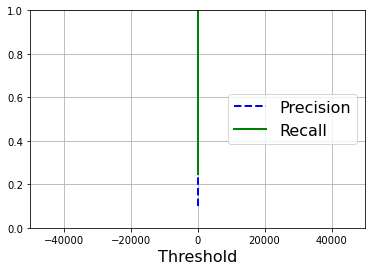

<Figure size 576x288 with 0 Axes>

数字 1 的阈值——精度/召回率曲线图：



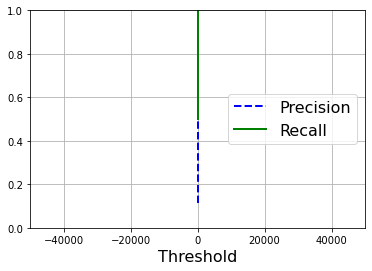

<Figure size 576x288 with 0 Axes>

数字 2 的阈值——精度/召回率曲线图：



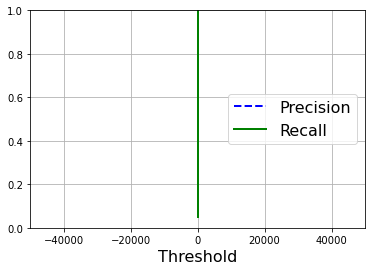

<Figure size 576x288 with 0 Axes>

数字 3 的阈值——精度/召回率曲线图：



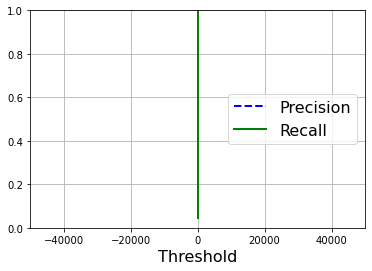

<Figure size 576x288 with 0 Axes>

数字 4 的阈值——精度/召回率曲线图：



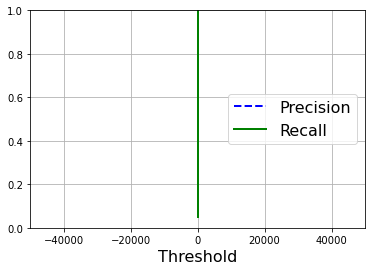

<Figure size 576x288 with 0 Axes>

数字 5 的阈值——精度/召回率曲线图：



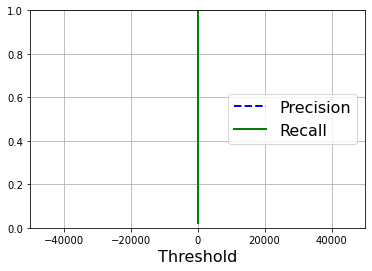

<Figure size 576x288 with 0 Axes>

数字 6 的阈值——精度/召回率曲线图：



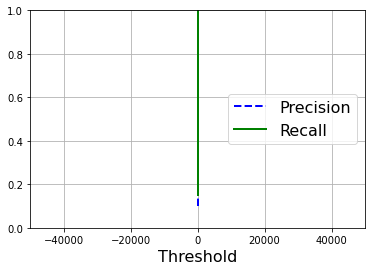

<Figure size 576x288 with 0 Axes>

数字 7 的阈值——精度/召回率曲线图：



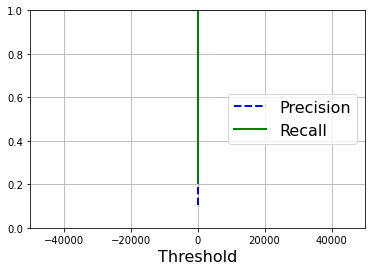

<Figure size 576x288 with 0 Axes>

数字 8 的阈值——精度/召回率曲线图：



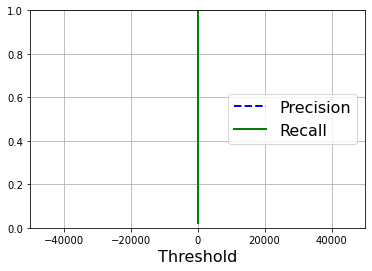

<Figure size 576x288 with 0 Axes>

数字 9 的阈值——精度/召回率曲线图：



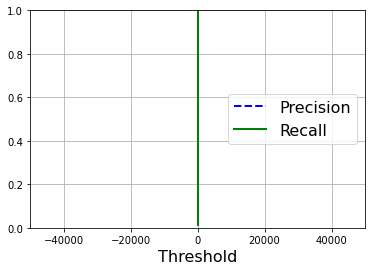

<Figure size 576x288 with 0 Axes>

0

In [18]:
# 绘制阈值与精度|召回率的曲线图--------------可选不同算法模型

# 导入相关函数
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
# 当前环境要有:X_train,y_train

# 画图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    plt.figure(figsize=(8, 4))                  # Not shown

# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()

# 画出每个数字的阈值——精度/召回率曲线
def draw_num_pr_threshold(model):
    # 先给各个数字分类
    y_train_set = []
    model_list = []
    y_scores_set = []
    pr_curve_set = []
    for i in range(10):
        y_train_set.append(y_train==str(i))
        print(y_train_set[i])
    # 模型可以直接用,无需重复训练
    for i in range(10):
        y_scores_set.append(cross_val_predict(model, X_train, y_train_set[i], cv=3,method="predict_proba"))
    for i in range(10):
        precisions, recalls, thresholds = precision_recall_curve(y_train_set[i], y_scores_set[i][:,1]) #
        pr_curve_set.append([precisions, recalls, thresholds])
    for i in range(10):
        print('数字 '+str(i)+' 的阈值——精度/召回率曲线图：\n')
        plot_precision_recall_vs_threshold(pr_curve_set[i][0], pr_curve_set[i][1], pr_curve_set[i][2])
        plt.show()
    return 0

draw_num_pr_threshold(rf_clf)
# 训练大概5-6min

# 绘制ROC曲线
- 用来比较多个模型
- ROC分数/ROC曲线

数字 0 的ROC曲线如下,对应的ROC分数为: 0.9994608287853223



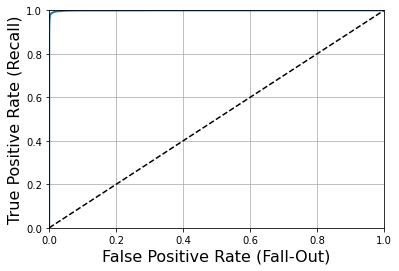

<Figure size 576x432 with 0 Axes>

数字 1 的ROC曲线如下,对应的ROC分数为: 0.99925253735645



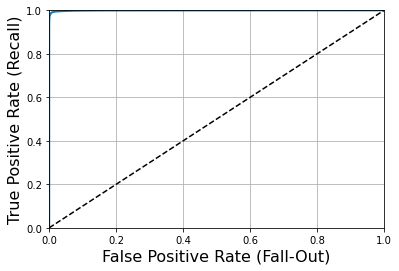

<Figure size 576x432 with 0 Axes>

数字 2 的ROC曲线如下,对应的ROC分数为: 0.9973249719900696



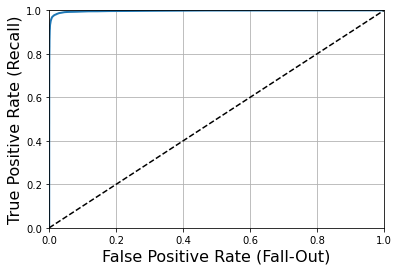

<Figure size 576x432 with 0 Axes>

数字 3 的ROC曲线如下,对应的ROC分数为: 0.9959177958184797



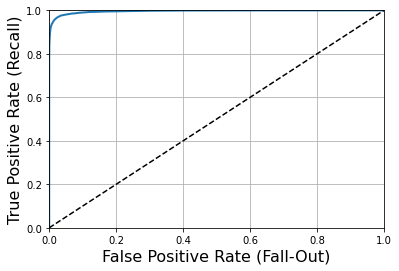

<Figure size 576x432 with 0 Axes>

数字 4 的ROC曲线如下,对应的ROC分数为: 0.9983299068561473



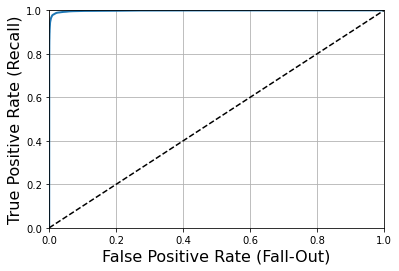

<Figure size 576x432 with 0 Axes>

数字 5 的ROC曲线如下,对应的ROC分数为: 0.9984414702402529



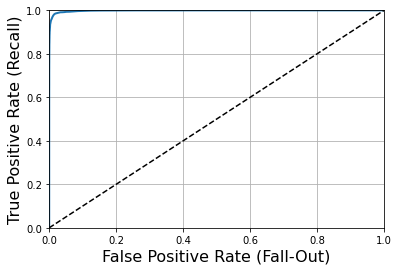

<Figure size 576x432 with 0 Axes>

数字 6 的ROC曲线如下,对应的ROC分数为: 0.9992188913711808



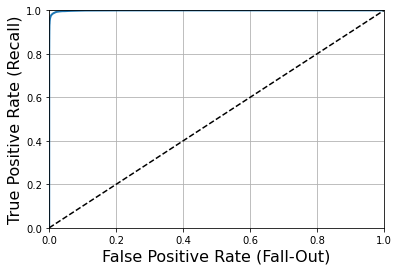

<Figure size 576x432 with 0 Axes>

数字 7 的ROC曲线如下,对应的ROC分数为: 0.9980863851758107



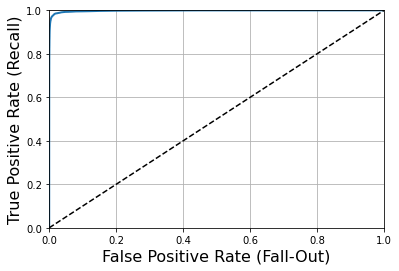

<Figure size 576x432 with 0 Axes>

数字 8 的ROC曲线如下,对应的ROC分数为: 0.9966420695430803



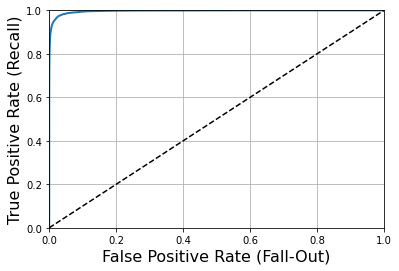

<Figure size 576x432 with 0 Axes>

数字 9 的ROC曲线如下,对应的ROC分数为: 0.9952987145841313



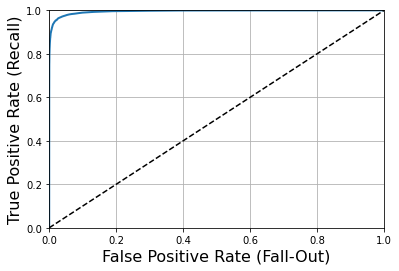

<Figure size 576x432 with 0 Axes>

In [19]:
# 写一个绘制某种model的每个数字ROC曲线的函数--------------用来比较不同的算法模型

# 导入依赖
from sklearn.metrics import roc_curve,roc_auc_score
# 当前环境要有:X_train,y_train

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# 画图
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown
    plt.figure(figsize=(8, 6))                                # Not shown

def draw_model_roc(model):
    # 先给各个数字分类
    y_train_set = []
    model_list = []
    y_scores_set = []
    roc_curve_set = []
    for i in range(10):
        y_train_set.append(y_train==str(i))
    for i in range(10):
        y_scores = cross_val_predict(model, X_train, y_train_set[i], cv=3,method="predict_proba")
        y_scores_set.append(y_scores)
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(y_train_set[i], y_scores_set[i][:,1])
        roc_curve_set.append([fpr, tpr, thresholds])
    for i in range(10):
        fpr = roc_curve_set[i][0]
        tpr = roc_curve_set[i][1]
        roc_score = roc_auc_score(y_train_set[i],y_scores_set[i][:,1])
        print('数字 '+str(i)+' 的ROC曲线如下,对应的ROC分数为: '+str(roc_score)+'\n')
        plot_roc_curve(fpr, tpr)
        plt.show()

draw_model_roc(rf_clf)
# 差不多18min